In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import libsynth as synth
import pandas as pd
from rdkit import Chem

### Read and Prepare Core Molecule

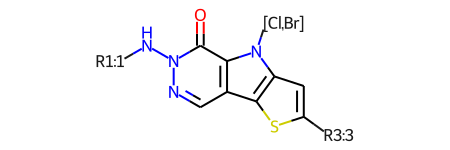

In [2]:
core = Chem.MolFromMolFile('../input/demo/core_1.mol')
synth.perceive_rgroups(core)
list_atoms = synth.perceive_list_atoms(core) # empty dictionary if no list atoms present on core
core

In [3]:
# making sure the R-atom mappings do not conflict with the list atom mappings
for atom in core.GetAtoms():
    if atom.HasQuery():
        print(atom.GetSymbol(), atom.GetAtomMapNum())

R3 3
Cl 4
R1 1


### Read and Prepare Reagents

In [4]:
# R1 - reading reagents
r1_dir = '../input/demo/R1'
r1_mols = synth.getMolsFromDir(r1_dir) # only .mol files
print(f'{len(r1_mols)} reagents found for R1')

# R3 - reading reagents
r3_dir = '../input/demo/R3'
r3_mols = synth.getMolsFromDir(r3_dir) # only .mol files
print(f'{len(r3_mols)} reagents found for R3')

# preparing the reagents
attachments = {} # dict for attachments - each key is the R isotope number (i.e., 1 for R1)
r1_mols_peeled = []
r3_mols_peeled = []

print(f'Processing reagents for R1')
for mol in r1_mols:
    peeled = synth.peel_reagent(mol, 1)
    if peeled:
        r1_mols_peeled.append(peeled)
print(f'Using {len(r1_mols_peeled)} reagents for R1')
attachments[1] = r1_mols_peeled

print(f'Processing reagents for R3')
for mol in r3_mols:
    peeled = synth.peel_reagent(mol, 3)
    if peeled:
        r3_mols_peeled.append(peeled)
print(f'Using {len(r3_mols_peeled)} reagents for R1')
attachments[3] = r3_mols_peeled

# add list atoms to attachment dict
if len(list_atoms) > 0:
    attachments.update(list_atoms)

# get expected library size
exp_size = synth.get_expected_size(attachments)
print(f'Expected Library Size: {exp_size}')

15 reagents found for R1
54 reagents found for R3
Processing reagents for R1
Using 15 reagents for R1
Processing reagents for R3
Using 54 reagents for R1
Expected Library Size: 1620


### Enumeration

In [5]:
enum_mols = synth.enumerate_virtual_library(core, attachments)
len(enum_mols)

1620

### Calculate Properties

,SMILES,Molecule,MolWt,NumHDonors,NumHAcceptors,MolLogP,TPSA,MolMR,BertzCT
0,COc1cccc(OC)c1CNn1ncc2c3sc(-c4cccnc4)cc3n(Cl)c...,,467.938,1.0,9.0,4.23750,83.20,126.4687,1470.557927
1,COc1cccc(OC)c1CNn1ncc2c3sc(-c4cccnc4)cc3n(Br)c...,,512.389,1.0,9.0,4.39360,83.20,129.5427,1470.557927
2,COc1cccc(OC)c1CNn1ncc2c3sc(-c4c(C)noc4C)cc3n(C...,,485.953,1.0,10.0,4.44734,96.34,128.2087,1523.101617
3,COc1cccc(OC)c1CNn1ncc2c3sc(-c4c(C)noc4C)cc3n(B...,,530.404,1.0,10.0,4.60344,96.34,131.2827,1523.101617
4,COc1cccc(OC)c1CNn1ncc2c3sc(-c4ccoc4)cc3n(Cl)c2...,,456.911,1.0,9.0,4.43550,83.45,120.9397,1429.880943
5,COc1cccc(OC)c1CNn1ncc2c3sc(-c4ccoc4)cc3n(Br)c2...,,501.362,1.0,9.0,4.59160,83.45,124.0137,1429.880943
6,COc1cccc(OC)c1CNn1ncc2c3sc(-c4ccncc4)cc3n(Cl)c...,,467.938,1.0,9.0,4.23750,83.20,126.4687,1470.557927
7,COc1cccc(OC)c1CNn1ncc2c3sc(-c4ccncc4)cc3n(Br)c...,,512.389,1.0,9.0,4.39360,83.20,129.5427,1470.557927
8,COc1cccc(OC)c1CNn1ncc2c3sc(-c4ccc(F)cn4)cc3n(C...,,485.928,1.0,9.0,4.37660,83.20,126.4267,1522.015709
9,COc1cccc(OC)c1CNn1ncc2c3sc(-c4ccc(F)cn4)cc3n(B...,,530.379,1.0,9.0,4.53270,83.20,129.5007,1522.015709

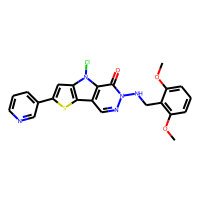
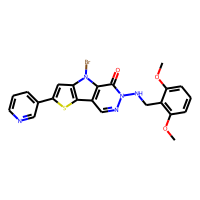
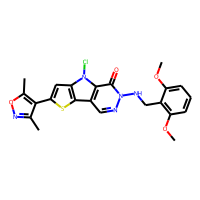
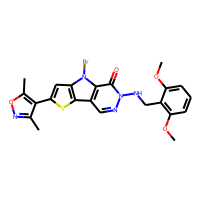
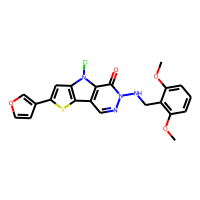
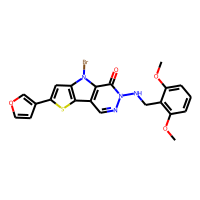
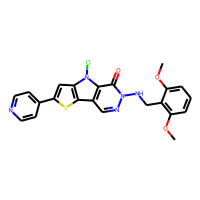
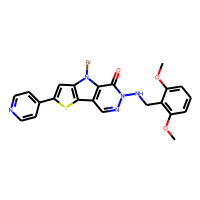
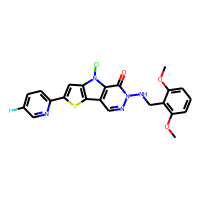
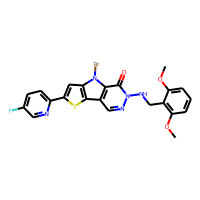

In [6]:
# convert mols to smiles
enum_smiles = [Chem.MolToSmiles(mol) for mol in enum_mols]

# add smiles to dataframe
df = pd.DataFrame(enum_smiles, columns=['SMILES'])
Chem.PandasTools.AddMoleculeColumnToFrame(df, smilesCol='SMILES', molCol='Molecule')

for i, row in df.iterrows():
    descs = synth.calc_desc(row['Molecule'])
    df.loc[i,synth.desc_names] = descs
    
df.head(10)

In [12]:
Chem.PandasTools.SaveXlsxFromFrame(df, outFile='../output/demo/lib.xlsx', molCol='Molecule', size=(300,300))